In [ ]:
from __init__ import PRP; import sys
sys.path.append(PRP + 'veros/')

from datetime import datetime
from jax import config
config.update("jax_enable_x64", True)

import jax
sys.path.append(PRP)

from scripts.load_runtime import * #Setup parameters for veros 
from setups.acc.acc_learning import ACCSetup

import jax.numpy as jnp
from jax import vmap

from tqdm import tqdm

Differentiable Veros Experimental version
Importing core modules
 Using computational backend jax on cpu
  Kernels are compiled during first iteration, be patient
 Runtime settings are now locked



In [2]:
from functools import partial

# Spin-Up

In [7]:
# Spin-up 
warmup_steps = 200
acc = ACCSetup()
acc.setup()
with acc.state.settings.unlock() :
    acc.state.settings.enable_eke = False

with acc.state.variables.unlock() :
     acc.state.variables.r_bot += 1e-5
     acc.state.variables.K_gm_0 += 1000.0

def ps(state) : 
    n_state = state.copy()
    acc.step(n_state)
    return n_state

step_jit = jax.jit(ps)

state = acc.state.copy()
for step in tqdm(range(warmup_steps)) :
    state = step_jit(state)

Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075


100%|██████████| 200/200 [00:05<00:00, 38.07it/s] 


# Compute derivative

In [9]:
class autodiff() :
    def __init__(self, step_function, agg_function,  var_name) :
        """
            Computes derivative dL/dvar with L in R and var in R
            step_function is the function done n iterations
            agg_function is computed at the end to go from R^space -> R
            var_name : name of the variable in the state to differentiatiat w.r.t
        """
        self.agg_function = agg_function
        self.step_function = partial(autodiff.pure, step=step_function)
        self.var_name = var_name

    @staticmethod
    def pure(state, step) :
        """
            Convert the state function into a "pure step" copying the input state
        """
        n_state = state.copy()
        step(n_state)  # This is a function that modifies state object inplace
        return n_state

    @staticmethod
    def set_var(var_name, state, var_value):
        n_state = state.copy()
        vs = n_state.variables
        with n_state.variables.unlock():
            setattr(vs, var_name, var_value)
        return n_state
    
    def rollout(self, n_state, iterations) :
        for _ in range(iterations):
                    n_state = self.step_function(n_state)
        return n_state

    def g(self, state, var_value, iterations=1, **kwargs):
        def loss_fn(v):
            # rollout for `iterations` steps
            n_state = autodiff.set_var(self.var_name, state, v)
            n_state = self.rollout(n_state, iterations)
            return self.agg_function(n_state)
    
        loss, grad = jax.value_and_grad(loss_fn)(var_value)
        return loss, grad

In [13]:
def agg_function(state) :
    return (state.variables.temp ** 2).sum()

var_dev = 'K_gm_0'
it = 2

In [14]:
vjpm_nr = autodiff(acc.step, agg_function, var_dev)

vjpm_nr.step_function = jax.jit(vjpm_nr.step_function)
vjpm_nr.agg_function = jax.jit(vjpm_nr.agg_function)

vjpm_nr.step_function = jax.checkpoint(vjpm_nr.step_function) # Remat to save memory


loss_and_grad_nr = lambda s, v, it: vjpm_nr.g(s, v, iterations=it)

In [15]:
loss_and_grad_nr(acc.state, 1e-5, 2)

(Array(6645090.47804146, dtype=float64),
 Array(7.14051524e-06, dtype=float64, weak_type=True))

# Parameter fitting experiment 

We try to fit a variable ("r_bot" or other) so that the state after it is similar to a target state. 

In [16]:
pred_iter = 5
targe_state = vjpm_nr.rollout(acc.state, iterations=pred_iter)
# We fix the target state iterating from the initial configuration

In [17]:
def agg_function(state) :
    return ((state.variables.temp - targe_state.variables.temp) ** 2).sum()

In [18]:
vjpm_nr = autodiff(acc.step, agg_function, var_dev)

vjpm_nr.step_function = jax.jit(vjpm_nr.step_function)
vjpm_nr.agg_function = jax.jit(vjpm_nr.agg_function)

vjpm_nr.step_function = jax.checkpoint(vjpm_nr.step_function) # Remat to save memory


loss_and_grad_nr = lambda s, v, it: vjpm_nr.g(s, v, iterations=it)

In [19]:
loss_and_grad_nr(acc.state, 0.0, pred_iter)

(Array(8.08886431e-06, dtype=float64),
 Array(-1.61052325e-08, dtype=float64, weak_type=True))

In [27]:
params = jnp.linspace(800, 1200, 10) #jnp.linspace(-4e-5, 4e-5, 10) (for rbots)

In [28]:
losses = []
grads = []
for pr in params :
    loss, grad = loss_and_grad_nr(acc.state, pr, pred_iter)
    losses.append(loss)
    grads.append(grad)

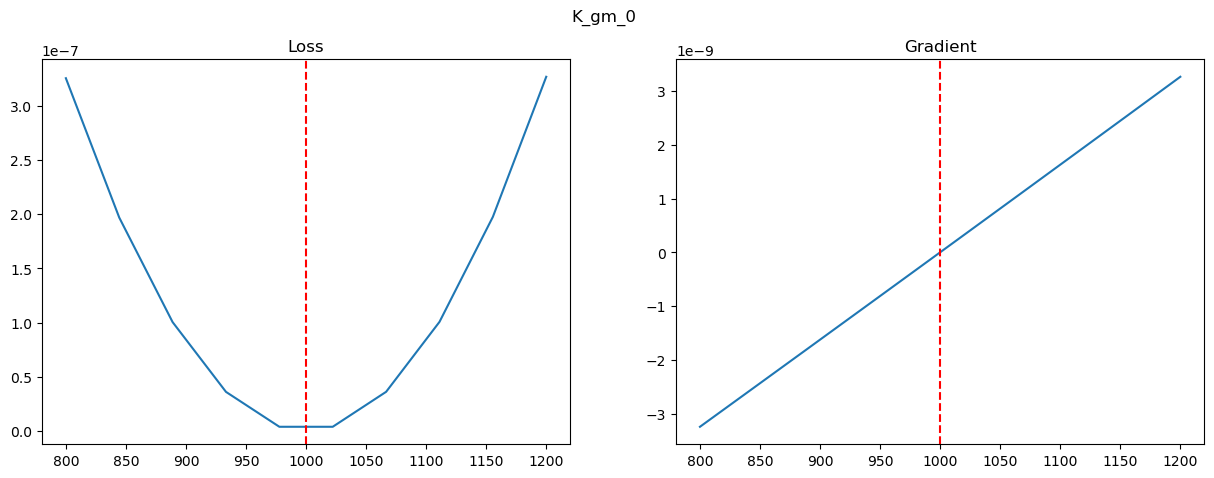

In [32]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
fig.suptitle(f'{var_dev}')
axs[0].set_title('Loss')
axs[0].plot(params, losses)
axs[0].axvline(getattr(acc.state.variables, var_dev), color='r', linestyle='dashed')
axs[1].set_title('Gradient')
axs[1].plot(params, grads)
axs[1].axvline(getattr(acc.state.variables, var_dev), color='r', linestyle='dashed')